# Variational AutoEncoder (VAE)

In [ ]:
#  https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb
#  https://github.com/AntixK/PyTorch-VAE
#  https://github.com/GuHongyang/VaDE-pytorch

In [1]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt

In [2]:
# https://pytorch.org/docs/stable/notes/randomness.html
SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

import random
random.seed(SEED)
import datetime

In [3]:
# Model Hyperparameters

dataset_path = './datasets'

cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 128

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30

# Load Dataset

In [4]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

# Model

In [5]:
def block(in_c,out_c):
    layers=[
        nn.Linear(in_c,out_c),
        nn.ReLU(True)
    ]
    return layers

In [6]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

# class Encoder(nn.Module):
    
#     def __init__(self,input_dim=784,inter_dims=[500,500,2000],hid_dim=10):
#         super(Encoder,self).__init__()

#         self.encoder=nn.Sequential(
#             *block(input_dim,inter_dims[0]),
#             *block(inter_dims[0],inter_dims[1]),
#             *block(inter_dims[1],inter_dims[2]),
#         )

#         self.mu_z=nn.Linear(inter_dims[-1],hid_dim)
#         self.log_var_z=nn.Linear(inter_dims[-1],hid_dim)

#     def forward(self, x):
#         e=self.encoder(x)

#         mu=self.mu_z(e)
#         log_var=self.log_var_z(e)

#         return mu, log_var

class Encoder(nn.Module):
    
    def __init__(self,input_dim=784,inter_dims=[400],hid_dim=200):
        super(Encoder,self).__init__()

        self.encoder=nn.Sequential(
            *block(input_dim,inter_dims[0]),
            # *block(inter_dims[0],inter_dims[1]),
            # *block(inter_dims[1],inter_dims[2]),
        )

        self.mu_z=nn.Linear(inter_dims[-1],hid_dim)
        self.log_var_z=nn.Linear(inter_dims[-1],hid_dim)

    def forward(self, x):
        e=self.encoder(x)

        mu=self.mu_z(e)
        log_var=self.log_var_z(e)

        return mu, log_var        

In [7]:
# class Decoder(nn.Module):
#     def __init__(self,input_dim=784,inter_dims=[500,500,2000],hid_dim=10):
#         super(Decoder,self).__init__()

#         self.decoder=nn.Sequential(
#             *block(hid_dim,inter_dims[-1]),
#             *block(inter_dims[-1],inter_dims[-2]),
#             *block(inter_dims[-2],inter_dims[-3]),
#             nn.Linear(inter_dims[-3],input_dim),
#             nn.Sigmoid()
#         )

#     def forward(self, z):
#         x_hat=self.decoder(z)

#         return x_hat

class Decoder(nn.Module):
    def __init__(self,input_dim=784,inter_dims=[400],hid_dim=200):
        super(Decoder,self).__init__()

        self.decoder=nn.Sequential(
            *block(hid_dim,inter_dims[-1]),
            # *block(inter_dims[-1],inter_dims[-2]),
            # *block(inter_dims[-2],inter_dims[-3]),
            # nn.Linear(inter_dims[-3],input_dim),

            nn.Linear(inter_dims[-1],input_dim),

            nn.Sigmoid()
        )

    def forward(self, z):
        x_hat=self.decoder(z)

        return x_hat

In [8]:
def reparameterization(mean, std):
    epsilon = torch.randn_like(std).to(DEVICE)        # sampling epsilon        
    z = mean + std*epsilon                          # reparameterization trick
    return z

In [9]:
class Model(nn.Module):
    def __init__(self, encoder, decoder):
        super(Model, self).__init__()
        self.encoder = encoder
        self.decoder = decoder     
                
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = reparameterization(mu, torch.exp(0.5 * log_var))
        x_hat = self.decoder(z)
        
        return x_hat, mu, log_var

In [10]:
# encoder = Encoder(input_dim=784,inter_dims=[500,500,2000],hid_dim=10)
# # decoder and encoder are symetric, and for the arguments decides the dimension of each layer we look at the layers of decoder from "tail to head"
# decoder = Decoder(input_dim=784,inter_dims=[500,500,2000],hid_dim=10)

encoder=Encoder()
decoder=Decoder()

model = Model(encoder=encoder, decoder=decoder).to(DEVICE)

# Train the model

In [11]:
from torch.optim import Adam

def loss_function(x, x_hat, mu, log_var):
    reconstruction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='mean')
    KLD = - 0.5 * torch.mean(1+ log_var - mu ** 2 - log_var.exp())

    return reconstruction_loss + KLD, reconstruction_loss, KLD 

optimizer = Adam(model.parameters(), lr=lr)

In [12]:
print("Start training VAE...")
model.train()

loss_list = []
reconstruction_loss_list = []
KLD_list = []
for epoch in range(epochs):
    overall_loss = 0
    overall_reconstruction_loss = 0
    overall_KLD = 0
    overall_sample_number = 0
    for batch_idx, (x, _) in enumerate(train_loader):

        x = x.view(-1, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mu, log_var = model(x)
        loss, reconstruction_loss, KLD = loss_function(x, x_hat, mu, log_var)
        
        overall_loss += loss.item() * x.shape[0]
        overall_reconstruction_loss += reconstruction_loss.item() * x.shape[0]
        overall_KLD += KLD.item() * x.shape[0]
        overall_sample_number += x.shape[0]

        train_loss = overall_loss / overall_sample_number
        train_reconstruction_loss = overall_reconstruction_loss / overall_sample_number
        train_KLD = overall_KLD / overall_sample_number
        
        loss.backward()
        optimizer.step()

    loss_list.append(train_loss)
    reconstruction_loss_list.append(train_reconstruction_loss)
    KLD_list.append(train_KLD)

    # print(datetime.datetime.now().strftime('%Y-%m-%d  %H:%M:%S'), "\tEpoch", epoch + 1, ":", "\tKLD Loss: ", overall_KLD / overall_sample_number, "\treconstruction Loss: ", overall_reconstruction_loss / overall_sample_number, "\tLoss: ", overall_loss / overall_sample_number)

    print(datetime.datetime.now().strftime('%Y-%m-%d  %H:%M:%S'), " \tEpoch {}: \tKLD Loss: {:.6f} \treconstruction Loss: {:.6f} \tLoss: {:.6f}".format(epoch + 1, train_KLD, train_reconstruction_loss, train_loss))

print("Finish!!")

Start training VAE...
2021-08-16  15:11:07  	Epoch 1: 	KLD Loss: 0.013805 	reconstruction Loss: 0.246022 	Loss: 0.259827
2021-08-16  15:11:14  	Epoch 2: 	KLD Loss: 0.027442 	reconstruction Loss: 0.202921 	Loss: 0.230363
2021-08-16  15:11:22  	Epoch 3: 	KLD Loss: 0.031759 	reconstruction Loss: 0.192983 	Loss: 0.224742
2021-08-16  15:11:29  	Epoch 4: 	KLD Loss: 0.034225 	reconstruction Loss: 0.182276 	Loss: 0.216501
2021-08-16  15:11:36  	Epoch 5: 	KLD Loss: 0.036129 	reconstruction Loss: 0.172537 	Loss: 0.208666
2021-08-16  15:11:43  	Epoch 6: 	KLD Loss: 0.037930 	reconstruction Loss: 0.166025 	Loss: 0.203955
2021-08-16  15:11:51  	Epoch 7: 	KLD Loss: 0.039828 	reconstruction Loss: 0.160631 	Loss: 0.200459
2021-08-16  15:11:58  	Epoch 8: 	KLD Loss: 0.041287 	reconstruction Loss: 0.156627 	Loss: 0.197914
2021-08-16  15:12:06  	Epoch 9: 	KLD Loss: 0.042106 	reconstruction Loss: 0.154321 	Loss: 0.196427
2021-08-16  15:12:13  	Epoch 10: 	KLD Loss: 0.042611 	reconstruction Loss: 0.152774 	Lo

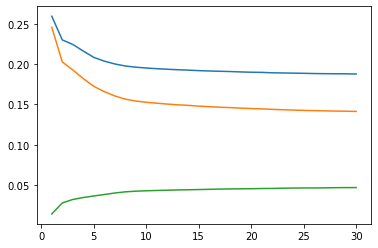

In [13]:
plt.figure()
plt.plot(range(1,epochs+1), loss_list, label = 'loss')
plt.plot(range(1,epochs+1), reconstruction_loss_list, label = 'reconstruction_loss')
plt.plot(range(1,epochs+1), KLD_list, label = 'KLD')
plt.show()

# Plotting

In [14]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(-1, x_dim)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)

        if batch_idx == 0: break

  0%|          | 0/79 [00:01<?, ?it/s]


  0%|          | 0/10000 [00:00<?, ?it/s]


In [15]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

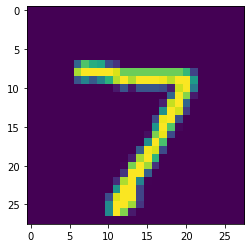

In [16]:
show_image(x, idx=0)

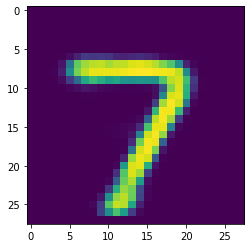

In [17]:
show_image(x_hat, idx=0)

In [18]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

def plot_x(i):
    model.eval()
    with torch.no_grad():
        x=test_dataset[i][0]
        x = x.view(-1, x_dim)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)

        fig = plt.figure(figsize=(8,8))
        plt.subplot(1,2,1)
        plt.title('Original image')
        plt.imshow(x.view(28,28).cpu().numpy())
        plt.subplot(1,2,2)
        plt.title('reconstructed image')
        plt.imshow(x_hat[0].view(28,28).cpu().numpy())
        # plt.imshow(x_hat[0].view(28,28).cpu().numpy(), cmap="gray")
        plt.show()

widget_a = widgets.BoundedIntText(value=1, min=0, max=9999, step=1)
widget_b = widgets.IntSlider(value=1, min=0, max=9999, step=1)
mylink = widgets.jslink((widget_a, 'value'), (widget_b, 'value'))

display(widget_a)
interact(plot_x, i = widget_b)

BoundedIntText(value=1, max=9999)

interactive(children=(IntSlider(value=1, description='i', max=9999), Output()), _dom_classes=('widget-interact…

<function __main__.plot_x(i)>

In [19]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

In [20]:
save_image(generated_images.view(-1, 1, 28, 28), 'generated_sample.png')

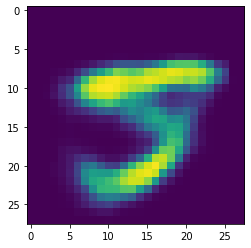

In [21]:
show_image(generated_images, idx=1)


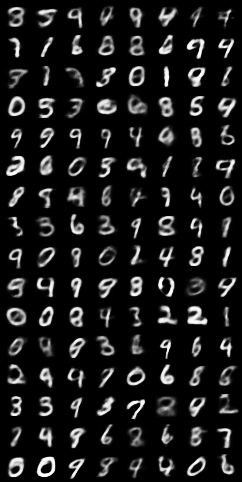

In [22]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename =r"./generated_sample.png")